In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plot
import seaborn
import re

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy.stats as stats

In [2]:
# Configure how graphs will show up in this notebook
%matplotlib inline
seaborn.set_context('notebook', rc={'figure.figsize': (50, 50)}, font_scale=1.5)

In [3]:
%%time
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 5.72 µs


In [5]:
%%time 
glove_840B_embeddings = load_embeddings('data/embeddings/glove/glove.840B.300d.txt')
glove_840B_embeddings.shape

CPU times: user 1min 55s, sys: 4.94 s, total: 2min
Wall time: 2min


(2196017, 300)

In [6]:
%%time 
glove_6B_300d_embeddings = load_embeddings('data/embeddings/glove/glove.6B.300d.txt')
glove_6B_300d_embeddings.shape

CPU times: user 20.9 s, sys: 593 ms, total: 21.5 s
Wall time: 21.7 s


(400000, 300)

In [7]:
## Loading word2vec
from conceptnet5.vectors.formats import load_word2vec_bin
w2v = load_word2vec_bin('data/embeddings/word2vec/word2vec-googlenews-300.bin.gz', nrows=2000000)

# word2vec is case-sensitive, so case-fold its labels
w2v.index = [label.casefold() for label in w2v.index]

# Now we have duplicate labels, so drop the later (lower-frequency) occurrences of the same label
w2v = w2v.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')

In [8]:
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

In [9]:
pos_words = load_lexicon('data/lexicons/hu_liu_2004/opinion-lexicon-English/positive-words.txt')
neg_words = load_lexicon('data/lexicons/hu_liu_2004/opinion-lexicon-English/negative-words.txt')

print(len(pos_words), len(neg_words))

2006 4783


In [10]:
import re
TOKEN_RE = re.compile(r"\w.*?\b")

def vecs_to_sentiment(model, vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    # this is a logarithm of the max margin for the classifier, 
    # similar to odds ratio (but not exact) log(p_1/p_0) = log(p_1)-log(p_0)
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(model, embeddings, words):
    vecs = embeddings.loc[embeddings.index.intersection(set(words))].dropna()
    # vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(model, vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)
    

def text_to_sentiment(model, embeddings, text):
    # tokenize the input phrase
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
    # send each token separately into the embedding, then the classifier
    sentiments = words_to_sentiment(model, embeddings, tokens)
    return sentiments['sentiment'].mean() # return the mean for the classifier        

In [11]:
def texts_to_sentiment(model, embeddings, texts):
    sentiments = pd.DataFrame(columns=['sentiment'])
    for text in texts:
        sentiments= pd.concat([sentiments, pd.DataFrame.from_records([{'sentiment': text_to_sentiment(model, embeddings, text)}])])
    return sentiments


In [12]:
def category_sentiment_table(model, embeddings, group_data, isText=False):
    frames = []
    for group, name_list in sorted(group_data.items()):
        lower_names = [name.lower() for name in name_list]
        if isText:
            sentiments = texts_to_sentiment(model, embeddings, lower_names)
        else:
            sentiments = words_to_sentiment(model, embeddings, lower_names)
        sentiments['group'] = group
        frames.append(sentiments)

    # Put together the data we got from each ethnic group into one big table
    return pd.concat(frames)

In [13]:
def train_model(embeddings, title = ''):
    # get the positive and negative embeddings
    pos_words_common = list(set(pos_words) & set(embeddings.index)) 
    neg_words_common = list(set(neg_words) & set(embeddings.index)) 
    pos_vectors = embeddings.loc[pos_words_common]
    neg_vectors = embeddings.loc[neg_words_common]
    vectors = pd.concat([pos_vectors, neg_vectors])
    targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
    labels = list(pos_vectors.index) + list(neg_vectors.index)

    # split the data
    train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
        train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)
    
    # train our model
    model = SGDClassifier(loss='log_loss', random_state=0, max_iter=100)
    model.fit(train_vectors, train_targets)
    
    # print out a goodness of fit
    accuracy = accuracy_score(model.predict(test_vectors), test_targets)
    print("Accuracy of sentiment: {:.2%}".format(accuracy))
    return model

In [14]:
model_6B = train_model(glove_6B_300d_embeddings)

Accuracy of sentiment: 91.35%


In [15]:
model_840B = train_model(glove_840B_embeddings)

Accuracy of sentiment: 95.77%


In [16]:
model_w2v = train_model(w2v)

Accuracy of sentiment: 93.99%


In [18]:
# Gender by Name. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C55G7X.

gender_names = pd.read_csv("gender_bias_test_data/uci_gendered_names/name_gender_dataset.csv")

gender_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147269 entries, 0 to 147268
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Name         147269 non-null  object 
 1   Gender       147269 non-null  object 
 2   Count        147269 non-null  int64  
 3   Probability  147269 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.5+ MB


In [19]:
num_f = gender_names[gender_names.Gender == 'F'].shape[0]
num_m = gender_names[gender_names.Gender == 'M'].shape[0]

print('There are {} female instants vs {} male instants'.format(num_f, num_m))

There are 89749 female instants vs 57520 male instants


In [20]:
GENDER_CAT_NAMES = {
    'female': gender_names[gender_names.Gender == 'F'].iloc[:num_m].Name.values,
    'male': gender_names[gender_names.Gender == 'M'].Name.values
}

In [21]:
def cat_sentiment(model, embeddings, group_data, isText=False, swarmPlot=True):
    print("---- Get the sentiment table")
    # get the name table of different people's names and save embeddings
    category_sentiments = category_sentiment_table(model, embeddings, group_data, isText)
    
    stats_params = []
    for group in category_sentiments.group.unique():
        stats_params.append(category_sentiments['sentiment'][category_sentiments['group'] == group])
    
    print("---- Calculate F_oneway")
    stats.f_oneway(*stats_params)
    fstat,pval = stats.f_oneway(*stats_params)
    print('F-statistic:',fstat,' With P-value:', pval)

    # Show the results on a swarm plot, with a consistent Y-axis
    matplotlib.pyplot.figure(figsize=(15,5))
    matplotlib.pyplot.subplot(121)
    plot = None
    if swarmPlot:
        plot = seaborn.swarmplot(x='group', y='sentiment', data=category_sentiments)
    else:
        plot = seaborn.violinplot(x='group', y='sentiment', data=category_sentiments)
    plot.set_ylim([-10, 10])
    matplotlib.pyplot.subplot(122)
    plot = seaborn.barplot(x='group', y='sentiment', data=category_sentiments, capsize=.1)
    matplotlib.pyplot.suptitle("hehe", fontsize=16)

---- Get the sentiment table
---- Calculate F_oneway
F-statistic: 58.48653835577706  With P-value: 2.104183981613819e-14


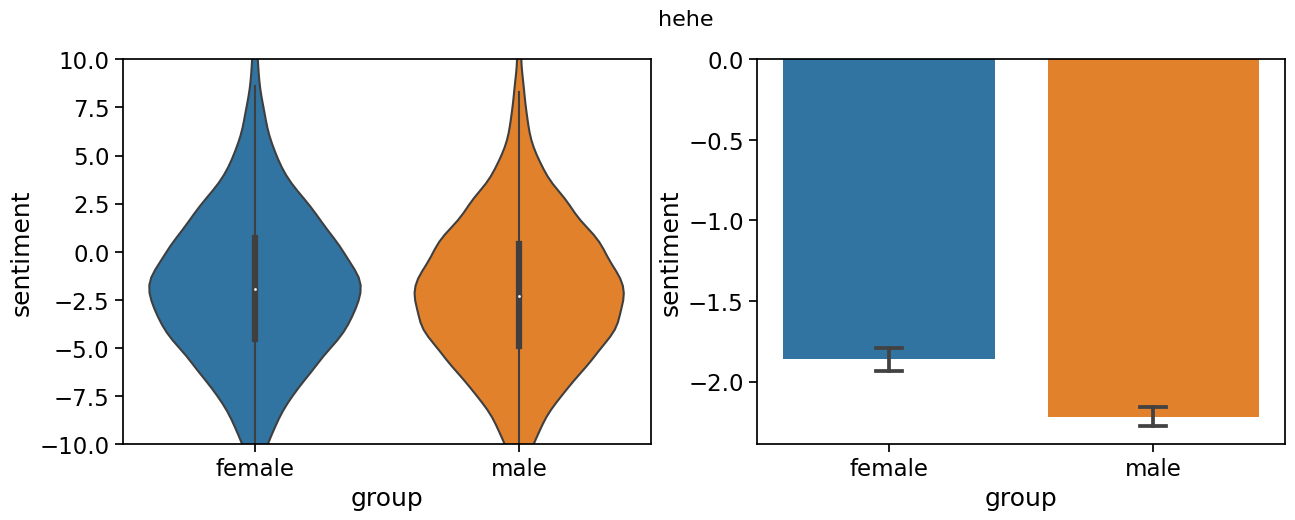

In [22]:
cat_sentiment(model_840B ,glove_840B_embeddings, GENDER_CAT_NAMES, False, False)

---- Get the sentiment table
---- Calculate F_oneway
F-statistic: 870.2442022360614  With P-value: 8.188687457841962e-190


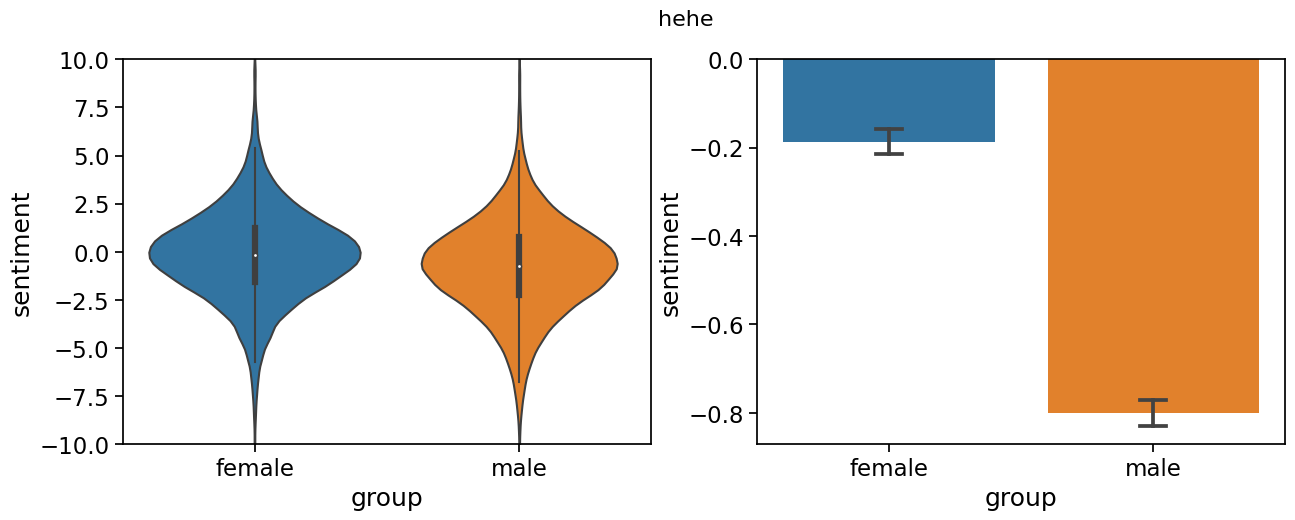

In [23]:
cat_sentiment(model_w2v ,w2v, GENDER_CAT_NAMES, False, False)

In [27]:
# Gendered Words: https://github.com/ecmonsen/gendered_words

gendered_words = pd.read_json('gender_bias_test_data/gendered_words/gendred_words.json')

gendered_words.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6923 entries, 0 to 6922
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   word             6923 non-null   object
 1   wordnet_senseno  6901 non-null   object
 2   gender           6923 non-null   object
 3   gender_map       568 non-null    object
dtypes: object(4)
memory usage: 216.5+ KB


In [28]:
gendered_words = gendered_words.drop('gender_map', axis=1)
gendered_words = gendered_words.drop('wordnet_senseno', axis=1)

In [29]:
gendered_words.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6923 entries, 0 to 6922
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    6923 non-null   object
 1   gender  6923 non-null   object
dtypes: object(2)
memory usage: 108.3+ KB


In [30]:
num_f_2 = gendered_words[gendered_words.gender == 'f'].shape[0]
num_m_2 = gendered_words[gendered_words.gender == 'm'].shape[0]

print('There are {} female instants vs {} male instants'.format(num_f_2, num_m_2))

There are 406 female instants vs 595 male instants


In [31]:
GENDER_CAT_NAMES_2 = {
    'female': gendered_words[gendered_words.gender == 'f'].iloc[:num_f_2].word.values,
    'male': gendered_words[gendered_words.gender == 'm'].iloc[:num_f_2].word.values
}

---- Get the sentiment table
---- Calculate F_oneway
F-statistic: 2.9802130382615712  With P-value: 0.08493029187764592


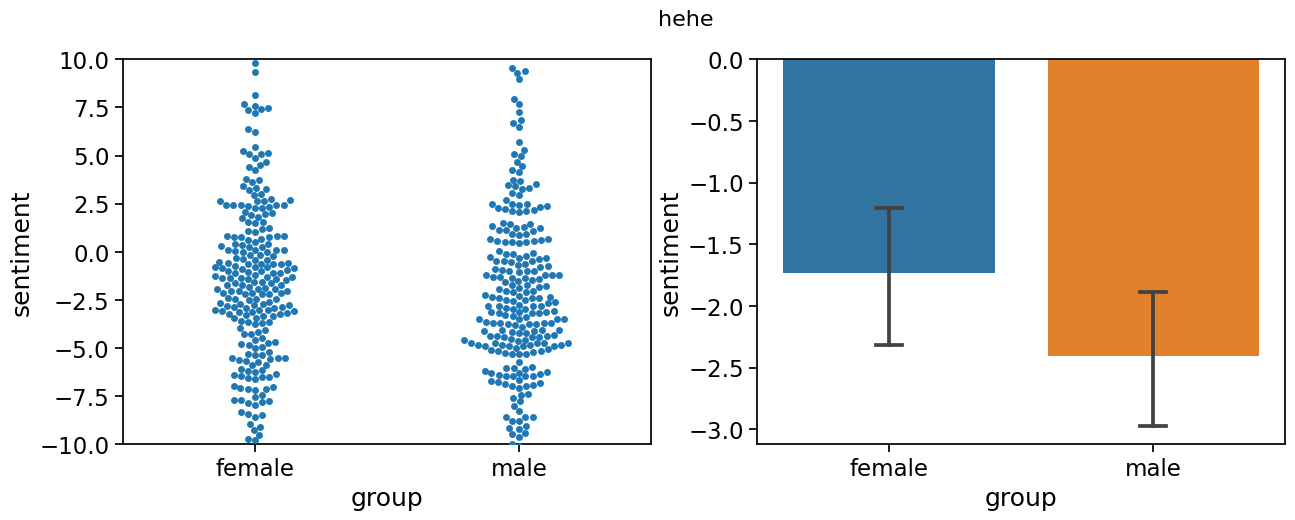

In [32]:
cat_sentiment(model_840B ,glove_840B_embeddings, GENDER_CAT_NAMES_2)

---- Get the sentiment table
---- Calculate F_oneway
F-statistic: 11.975828979142783  With P-value: 0.000584799253730029


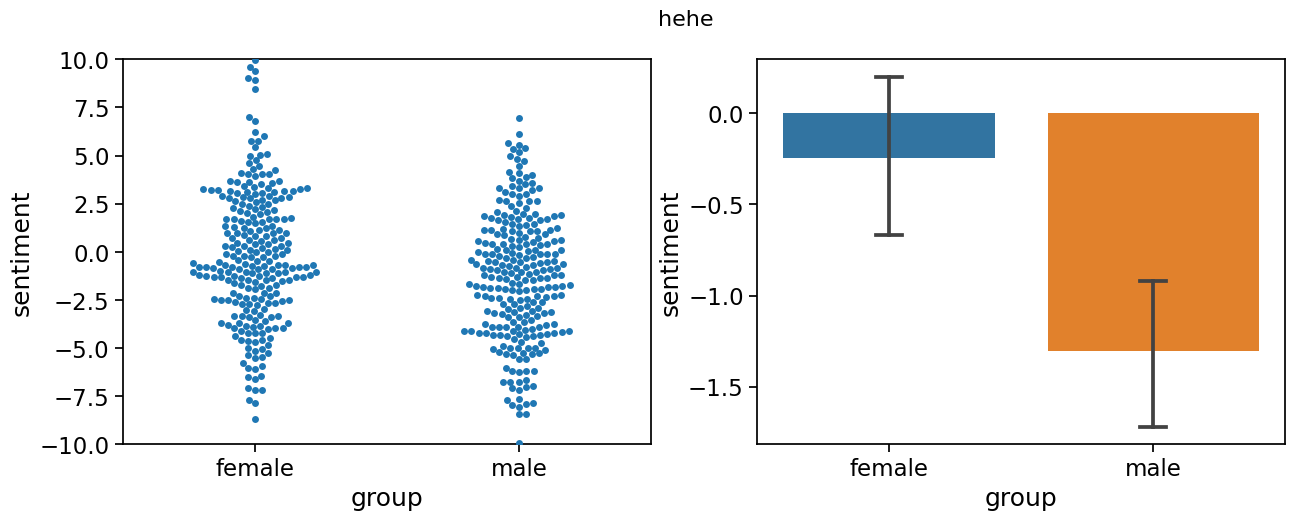

In [33]:
cat_sentiment(model_w2v ,w2v, GENDER_CAT_NAMES_2)

In [39]:
# Google Case study for gender bias translations
# https://ai.google/static/documents/case-study-translate-gender-bias.pdf

google_translation = pd.read_csv("gender_bias_test_data/google_translation_gender_bias/google_en_es_gender_bias.csv")

In [40]:
google_translation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sourceLanguage   1471 non-null   object
 1   targetLanguage   1471 non-null   object
 2   documentID       1471 non-null   int64 
 3   stringID         1471 non-null   object
 4   sourceText       1471 non-null   object
 5   translatedText   1471 non-null   object
 6   perceivedGender  1471 non-null   object
 7   entityName       1471 non-null   object
 8   sourceURL        1471 non-null   object
dtypes: int64(1), object(8)
memory usage: 103.6+ KB


In [41]:

google_translation = google_translation.drop(
    [
        'sourceLanguage', 'targetLanguage', 'documentID', 'stringID',
        'translatedText', 'entityName', 'sourceURL'
    ],
    axis=1)

In [42]:
google_translation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sourceText       1471 non-null   object
 1   perceivedGender  1471 non-null   object
dtypes: object(2)
memory usage: 23.1+ KB


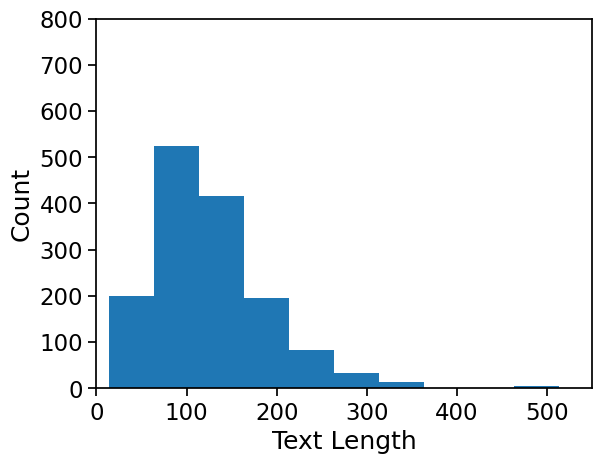

In [43]:
lengths = google_translation.sourceText.str.len()
plot.hist(lengths) 
plot.axis([0,550,0,800])
plot.xlabel('Text Length')
plot.ylabel('Count')
plot.show()

In [44]:
print("Max length is {}".format(max(lengths)))
print("Min length is {}".format(min(lengths)))
print("Top 10 lengths: ", lengths.value_counts().nlargest(10).to_dict())

Max length is 513
Min length is 14
Top 10 lengths:  {113: 17, 81: 15, 97: 14, 116: 14, 65: 14, 144: 14, 102: 14, 94: 13, 108: 13, 66: 13}


In [45]:
MAX_LENGTH_STR = 513
# Truncate and padd sentences with zeros
google_translation['short_str'] = google_translation['sourceText'].str.slice(0,MAX_LENGTH_STR).str.zfill(MAX_LENGTH_STR)

In [46]:
google_translation.perceivedGender.unique()

array(['Female', 'Male', 'Neutral'], dtype=object)

In [47]:
num_f_3 = google_translation[google_translation.perceivedGender == 'Female'].shape[0]
num_m_3 = google_translation[google_translation.perceivedGender == 'Male'].shape[0]

print('There are {} female instants vs {} male instants'.format(num_f_3, num_m_3))

There are 684 female instants vs 661 male instants


In [48]:
NUMBER_SAMPLES = 100
GENDER_CAT_NAMES_3 = {
    'female': google_translation[google_translation.perceivedGender == 'Female'].sample(n=NUMBER_SAMPLES).short_str.values,
    'male': google_translation[google_translation.perceivedGender == 'Male'].sample(n=NUMBER_SAMPLES).short_str.values
}

---- Get the sentiment table
---- Calculate F_oneway
F-statistic: 0.051183998602156625  With P-value: 0.8212490659232903
CPU times: user 3.04 s, sys: 6.71 s, total: 9.75 s
Wall time: 854 ms


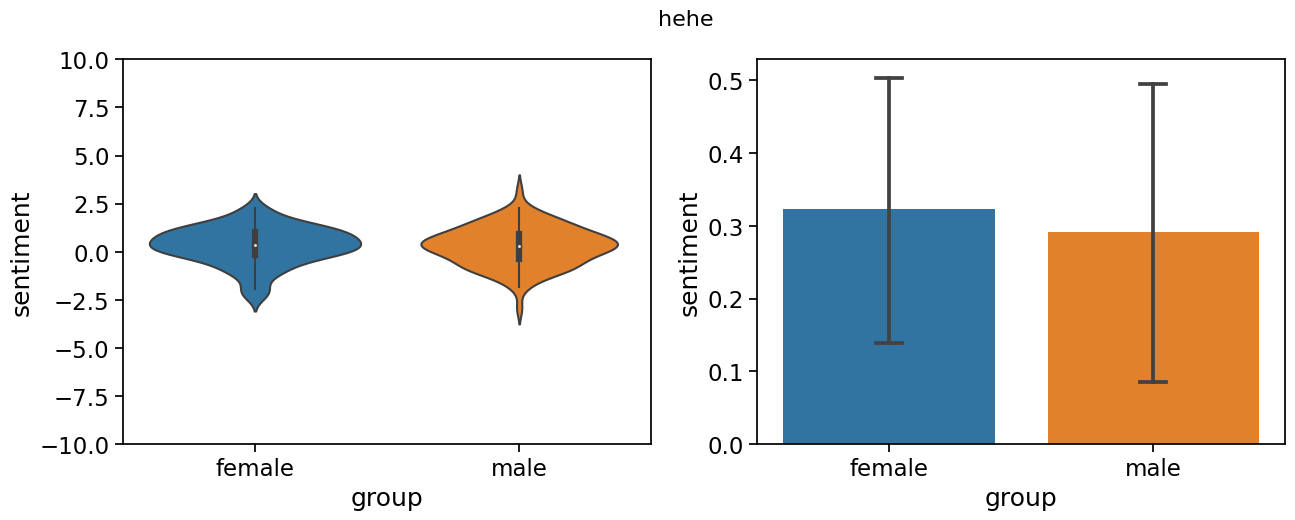

In [49]:
%%time
cat_sentiment(model_w2v ,w2v, GENDER_CAT_NAMES_3, True, False)

---- Get the sentiment table
---- Calculate F_oneway
F-statistic: 1.3939177342326572  With P-value: 0.23916093886410542
CPU times: user 2.75 s, sys: 6.19 s, total: 8.94 s
Wall time: 767 ms


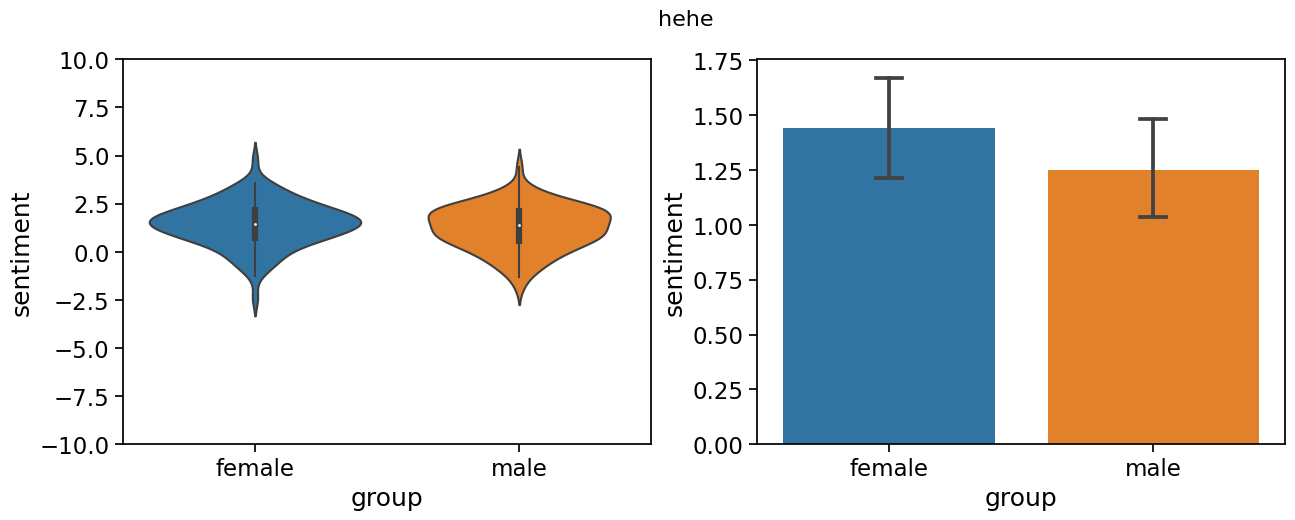

In [50]:
%%time
cat_sentiment(model_6B ,glove_6B_300d_embeddings, GENDER_CAT_NAMES_3, True, False)

---- Get the sentiment table
---- Calculate F_oneway
F-statistic: 2.4221853959303536  With P-value: 0.12122486869041973
CPU times: user 4min 42s, sys: 13.1 s, total: 4min 55s
Wall time: 4min 38s


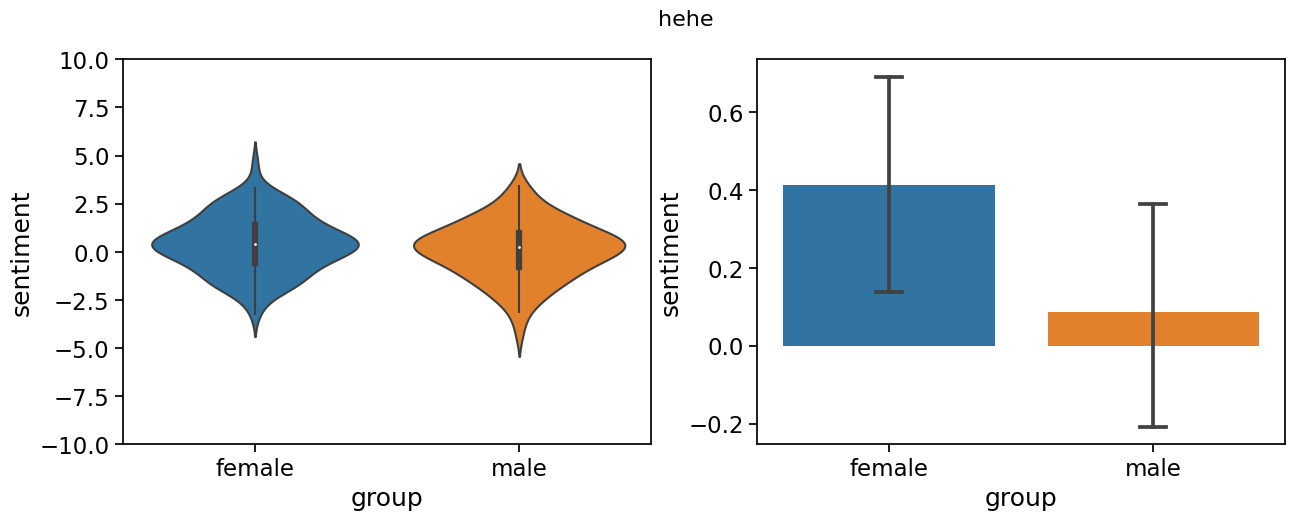

In [51]:
%%time
cat_sentiment(model_840B ,glove_840B_embeddings, GENDER_CAT_NAMES_3, True, False)

In [ ]:
# Other Biases to look into:

# religious
# gender
# ageism 
# 

# racial <- is probably the most obvious one